### Modelo de previsão de Churn

**Qual o nosso problema?**

Encontrar os clientes que tem alto risco de cancelamento (churn) para que o seja possível tomar medidas preventivas.

**Dados**

Dataset de 10000 clientes com informações demográficas, comportamentais e financeiras

In [18]:
## Importar as bibliotecas necessárias a princípio

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [19]:
## Carregar o dataset

df = pd.read_csv("customer_churn_business_dataset.csv")

In [20]:
## Verificar as colunas que existem no dataset

df.head()

,customer_id,gender,age,country,city,customer_segment,tenure_months,signup_channel,contract_type,monthly_logins,...,avg_resolution_time,complaint_type,csat_score,escalations,email_open_rate,marketing_click_rate,nps_score,survey_response,referral_count,churn
0,CUST_00001,Male,68,Bangladesh,London,SME,22,Web,Monthly,26,...,13.354360,Service,4.0,0,0.71,0.40,27,Satisfied,1,0
1,CUST_00002,Female,57,Canada,Sydney,Individual,9,Mobile,Monthly,7,...,25.140088,Billing,2.0,0,0.78,0.33,-19,Neutral,2,1
2,CUST_00003,Male,24,Germany,New York,SME,58,Web,Yearly,19,...,27.572928,Service,3.0,0,0.35,0.49,80,Neutral,1,0
3,CUST_00004,Male,49,Australia,Dhaka,Individual,19,Mobile,Yearly,34,...,26.420822,Technical,5.0,1,0.83,0.15,100,Neutral,0,0
4,CUST_00005,Male,65,Bangladesh,Delhi,Individual,52,Web,Monthly,20,...,26.674579,Technical,4.0,0,0.65,0.44,21,Unsatisfied,1,0


In [21]:
## Verificar o tipo de cada objeto, variáveis quantitativas e qualitativas são tratadas de maneiras diferentes na construção do modelo

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             10000 non-null  object 
 1   gender                  10000 non-null  object 
 2   age                     10000 non-null  int64  
 3   country                 10000 non-null  object 
 4   city                    10000 non-null  object 
 5   customer_segment        10000 non-null  object 
 6   tenure_months           10000 non-null  int64  
 7   signup_channel          10000 non-null  object 
 8   contract_type           10000 non-null  object 
 9   monthly_logins          10000 non-null  int64  
 10  weekly_active_days      10000 non-null  int64  
 11  avg_session_time        10000 non-null  float64
 12  features_used           10000 non-null  int64  
 13  usage_growth_rate       10000 non-null  float64
 14  last_login_days_ago     10000 non-null 

In [22]:
## Verificar se há nulos e em quais colunas

df.isnull().sum()

customer_id                  0
gender                       0
age                          0
country                      0
city                         0
customer_segment             0
tenure_months                0
signup_channel               0
contract_type                0
monthly_logins               0
weekly_active_days           0
avg_session_time             0
features_used                0
usage_growth_rate            0
last_login_days_ago          0
monthly_fee                  0
total_revenue                0
payment_method               0
payment_failures             0
discount_applied             0
price_increase_last_3m       0
support_tickets              0
avg_resolution_time          0
complaint_type            2045
csat_score                   0
escalations                  0
email_open_rate              0
marketing_click_rate         0
nps_score                    0
survey_response              0
referral_count               0
churn                        0
dtype: i

Aqui é possível ver que há nulos na coluna de reclamações, devemos tratá-la

In [23]:
## Aqui estou preenchendo os campos vazios dessa coluna com "None", indicando que não houve reclamações

df['complaint_type'] = df['complaint_type'].fillna('None')

Essa parte é muito necessária pois o modelo não entende campos vazios

In [24]:
## Aqui estou verificando se realmente não há mais nulos nesse campo

df['complaint_type'].isnull().sum()

np.int64(0)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'tenure_months'}>,
        <Axes: title={'center': 'monthly_logins'}>,
        <Axes: title={'center': 'weekly_active_days'}>],
       [<Axes: title={'center': 'avg_session_time'}>,
        <Axes: title={'center': 'features_used'}>,
        <Axes: title={'center': 'usage_growth_rate'}>,
        <Axes: title={'center': 'last_login_days_ago'}>],
       [<Axes: title={'center': 'monthly_fee'}>,
        <Axes: title={'center': 'total_revenue'}>,
        <Axes: title={'center': 'payment_failures'}>,
        <Axes: title={'center': 'support_tickets'}>],
       [<Axes: title={'center': 'avg_resolution_time'}>,
        <Axes: title={'center': 'csat_score'}>,
        <Axes: title={'center': 'escalations'}>,
        <Axes: title={'center': 'email_open_rate'}>],
       [<Axes: title={'center': 'marketing_click_rate'}>,
        <Axes: title={'center': 'nps_score'}>,
        <Axes: title={'center': 'referral_count'}>,
        

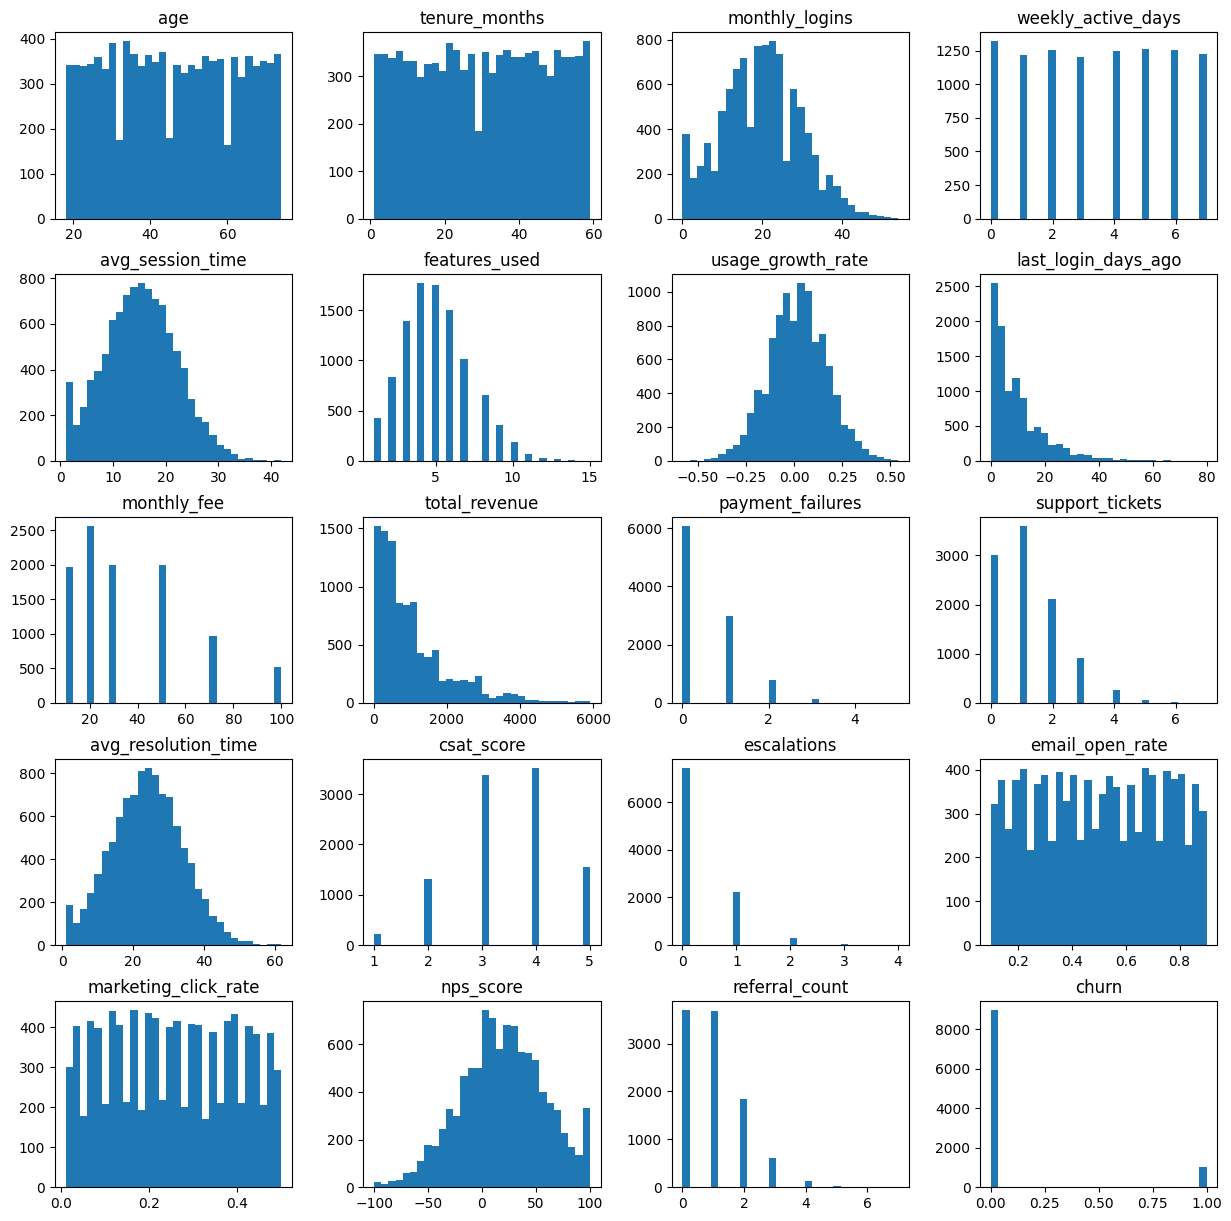

In [25]:
## Visão das distribuições das variáveis quantitativas

df.hist(figsize=(15, 15), bins=30, grid=False)

Algumas métricas, como user_growth_rate e avg_session_time parecem seguir distribuições próximas a distribuições normais, saber desses detalhes pode ser útil para análises futuras.

In [26]:
## Aqui estou removendo o campo de id do cliente, essa métrica não diz nada sobre o comportamento do mesmo

df = df.drop(columns='customer_id')

Esse próximo passo é super importante, usaremos o método **get_dummies** do Pandas, esse método permite que separemos nossas variáveis qualitativas em variáveis quantitativas, geralmente dividido entre 0 e 1, para que o modelo considere essas variáveis no treinamento.

In [27]:
df_ready = pd.get_dummies(df, drop_first= True)
df_ready.head()

,age,tenure_months,monthly_logins,weekly_active_days,avg_session_time,features_used,usage_growth_rate,last_login_days_ago,monthly_fee,total_revenue,...,contract_type_Yearly,payment_method_Card,payment_method_PayPal,discount_applied_Yes,price_increase_last_3m_Yes,complaint_type_None,complaint_type_Service,complaint_type_Technical,survey_response_Satisfied,survey_response_Unsatisfied
0,68,22,26,7,11.762372,5,0.06,7,30,660,...,False,False,True,True,False,False,True,False,True,False
1,57,9,7,5,26.846390,1,-0.28,2,30,270,...,False,True,False,False,True,False,False,False,False,False
2,24,58,19,5,23.380065,6,0.13,23,20,1160,...,True,True,False,False,False,False,True,False,False,False
3,49,19,34,7,24.243136,2,-0.17,24,30,570,...,True,False,False,True,False,False,False,True,False,False
4,65,52,20,6,18.872323,2,-0.16,2,50,2600,...,False,False,True,False,False,False,False,True,False,True


**Matriz de Correlação**

Por que é importante?

Para verificamos se há colinearidade nos dados, dados altamente colineares (ou seja, que tem uma correlação alta) podem acabar atrapalhando no treinamento do modelo.

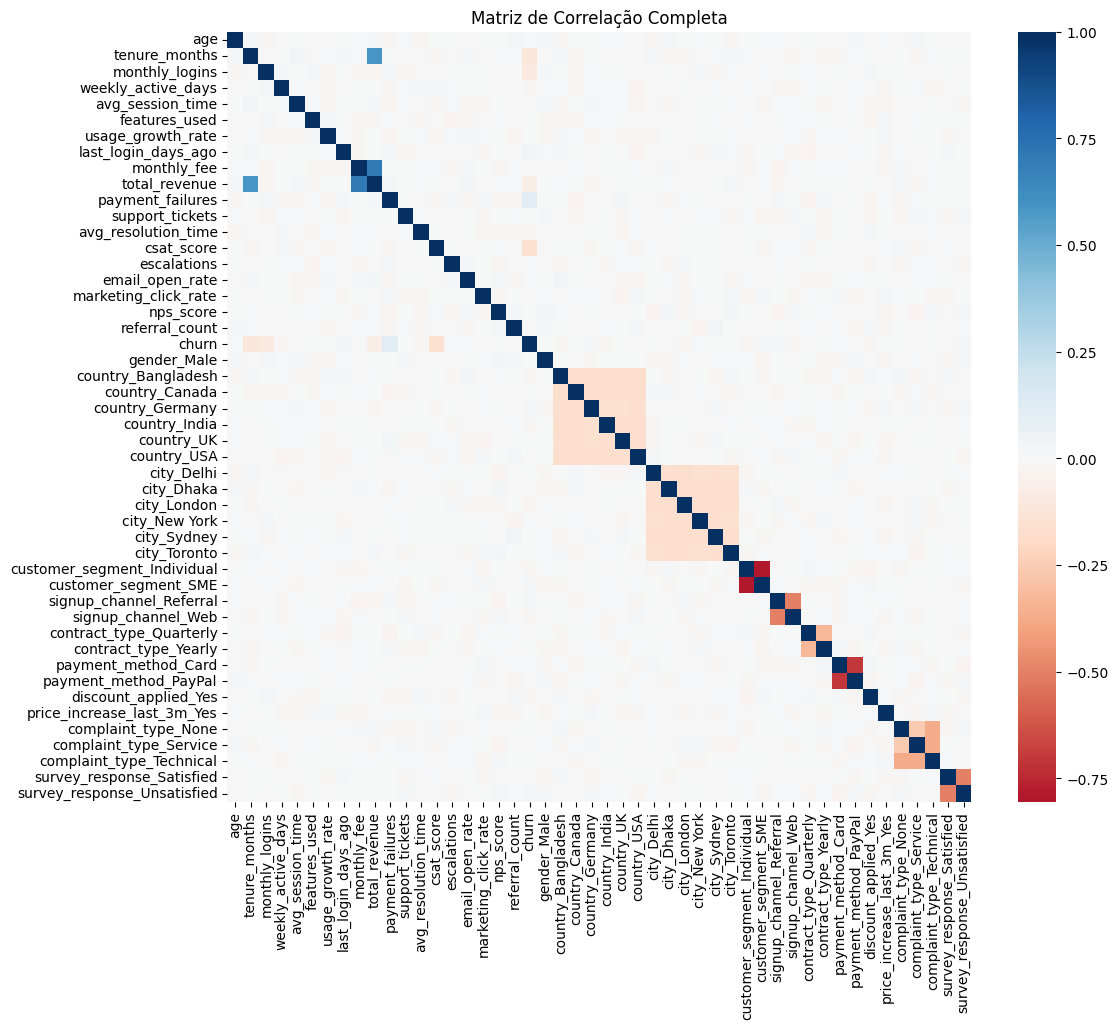

In [28]:
corr= df_ready.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='RdBu', center=0, annot=False)   
plt.title('Matriz de Correlação Completa')
plt.show()

Nessa parte acabamos a exploração e o tratamento dos dados, agora partiremos para a parte do treinamento.

**Qual o modelo escolhido?**

O modelo que eu escolhi foi o Random Forest, uma vez que é um modelo que entrega ótimos resultados sem necessidade de ajustar os hiperparâmetros, e visto que temos diversas variáveis, o Random Forest aplica diversas árvores e decisão e escolhe a mais equilibrada entre elas para fitar os dados.

In [29]:
## Importar as bibliotecas, aqui usaremos o scikit-learn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Escolher o modelo

model = RandomForestClassifier(random_state= 42, class_weight= 'balanced', max_depth= 3)

## Separar a variável alvo e os dados

X = df_ready.drop('churn', axis = 1)
y = df_ready['churn']

## Dividir os dados entre treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
print("Treino pronto")

Treino pronto


In [30]:
## Fitar o modelo

model.fit(X_train, y_train)
print("Modelo fitado")

Modelo fitado


C:\Users\eduardo.lucio_dp6\AppData\Local\Temp\ipykernel_25432\3975640729.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')


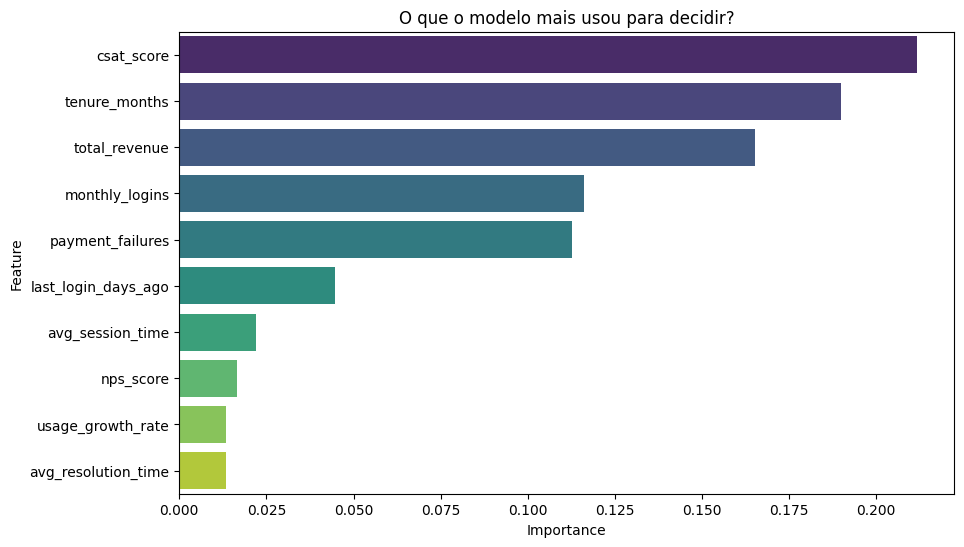

In [31]:
## Vendo a importância de cada variável no modelo

importancias = model.feature_importances_
nomes_colunas = X_train.columns

# Cria um DataFrame para visualizar
df_imp = pd.DataFrame({'Feature': nomes_colunas, 'Importance': importancias})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10)

# Plota
plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
plt.title('O que o modelo mais usou para decidir?')
plt.show()

In [32]:
## Dados previstos

y_pred = model.predict(X_test)

In [33]:
## Matriz de Confusão

print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))

Matriz de confusão:
 [[1379  401]
 [  73  147]]


**Como interpretar a matriz de confusão?**

a matriz de confusão é uma matriz $2$ x $2$ que compara os dados previstos com os reais para dizer aonde o modelo errou, ela devolve nessa forma:

| **VN**  | **FP**  |
| --- | --- |
| **FN**  | **VP**  |

VN = Verdadeiro Negativo 
FN = Falso Negativo
FP = Falso Positivo
VP = Verdadeiro Positivo

Basicamente, quanto maior os números da diagonal principal, melhor.

---------------------------------------------------------------------------------------------------------------------------

**Uma introdução as métricas de classificação**

**Acurácia**

Capacidade de prever corretamente o total. é dada pela fórmula:

$$

Acurácia = \frac{VP + VN}{VP + VN + FP + FN}

$$

**Precisão**

Qualidade dos positivos preditos, ou seja, de todos que realmente deram churn, quantos o modelo acertou?
É dado pela fórmula:

$$
Precisão = \frac{VP}{VP + FP}
$$

**Recall ou Sensibilidade**

Capacidade de encontrar positivos reais, ou seja, de todos que realmente deram churn, quantos o modelo conseguiu encontrar?
É dado pela fórmula:

$$
Recall = \frac{VP}{VP + FN}
$$

**F1-Score**

É a média harmônica entre precisão e recall. É usado quando você quer um modelo que não chute demais (Precisão ruim) nem deixe passar demais (Recall ruim). É a melhor métrica única para comparar modelos.
É dado pela fórmula:

$$
F1-Score = 2 * \frac{Precision * Recall}{Precision + Recall}

In [34]:
## Relatório de Classificação

print("Relatório de classificação\n",   classification_report(y_test, y_pred))

Relatório de classificação
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      1780
           1       0.27      0.67      0.38       220

    accuracy                           0.76      2000
   macro avg       0.61      0.72      0.62      2000
weighted avg       0.87      0.76      0.80      2000



In [44]:
## AJUSTE FINO
## Simulação do Threshold

y_proba = model.predict_proba(X_test)[:,1]

## Definir novo threshold

new_threshold = 0.4
y_pred_adjust = (y_proba >+ new_threshold).astype(int)

## Comparar os resultados

print("Relatório de classificação (Threshold = 0.4)\n", classification_report(y_test, y_pred_adjust))


Relatório de classificação (Threshold = 0.4)
               precision    recall  f1-score   support

           0       0.98      0.32      0.48      1780
           1       0.15      0.95      0.25       220

    accuracy                           0.39      2000
   macro avg       0.56      0.63      0.37      2000
weighted avg       0.89      0.39      0.45      2000



O Recall aumenta porque fomos menos exigentes na classificação. Ao baixar o Threshold, passamos a considerar como 'Risco' até aqueles clientes com probabilidades menores (ex: 30%), garantindo que menos cancelamentos passem despercebidos.

---------------------------------------------------------------------------------------------------------------------------


1. **Desempenho Geral** 

"O modelo final (Random Forest com profundidade limitada e pesos balanceados) atingiu um Recall de 67% para a classe de Churn. Isso significa que o algoritmo é capaz de identificar previamente 6/7 de cada 10 clientes que estão prestes a cancelar."

2. **Faca de dois gumes**

 "Para alcançar esse nível de detecção em uma base desbalanceada (apenas 10% de cancelamentos), o modelo sacrifica a Precisão. Isso gera um número considerável de falsos positivos (clientes que o modelo aponta como risco, mas que não sairiam)."

3. **Recomendação de Negócio** 

Devido à baixa precisão (alto número de alarmes falsos), recomenda-se utilizar este modelo para ações de retenção de baixo custo, como:

Campanhas de e-mail marketing automatizadas ('Sentimos sua falta').

Push notifications no app.

Sondagens de satisfação.
